# Monte Carlo Markov Chain Methods

We will try to fit the lightcurve with a model called the smooth broken power-law model.

$$F(t, \nu) = 2^{\frac{1}{s}} \left(\frac{\nu}{3 \text{GHz}} \right)^{\beta}F_{p}\left[\left( \frac{t}{t_{p}}\right)^{-s\alpha_{1}} + \left( \frac{t}{t_{p}}\right)^{-s\alpha_{2}} \right]^{\frac{-1}{s}}$$

In [50]:
# We do the required imports here as well as set up some helper functions
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
import re
import scipy
import emcee
import corner

Here we have recreated the first figure from the paper, ALso we have normalized the fluxes to use in the further analysis

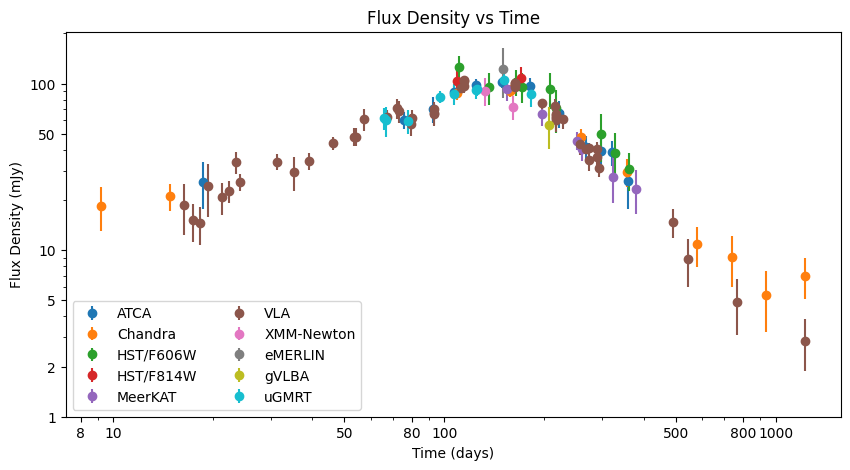

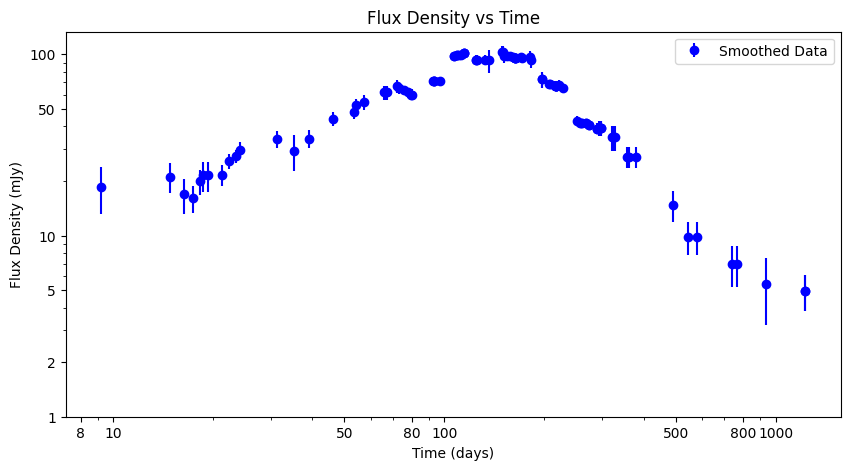

In [49]:


beta_paper = -0.584 # For the analysis taking only alpha_1, alpha_2 and s in MCMC

# Some preprocessing of the data
def Telescope_Filter(data, telescope):
    return data[data['Telescope'] == telescope]

def Frequency_Filter(data, freq):
    return data[data['Freq'] == freq]

data = ascii.read('data.txt')

# Remove all data points whose fluxD begins with <
data = data[~np.array([re.match(r'<', str(i)) is not None for i in data['FluxD']])]

# Convert the fluxD to float
data['FluxD'] = data['FluxD'].astype(float)
# Now we scale the fluxD for the data

for i in range(len(data)):
    data["FluxD"][i] = data["FluxD"][i] * (data["Freq"][i] / 3e9)**(-beta_paper)
    data["FluxDErr"][i] = data["FluxDErr"][i] * (data["Freq"][i] / 3e9)**(-beta_paper)

# Now we plot the data (Basically we have recreated figure 1 from the paper)
# Making the plot a bit wider
plt.figure(figsize=(10, 5))

# We colour each data point by the telescope used
telescopes = data['Telescope']
telescopes = np.unique(telescopes)
# List of 10 colours
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
for i, telescope in enumerate(telescopes):
    data_telescope = Telescope_Filter(data, telescope)
    plt.errorbar(data_telescope['T'], data_telescope['FluxD'], yerr=data_telescope['FluxDErr'], fmt='o', label=telescope, color=colors[i])

# Set logarithmic Scale
plt.xscale('log')
plt.yscale('log')
# Show the points 8, 10, 80 on the X axis, with label of the points
plt.xticks(ticks=[8, 10, 50, 80, 100, 500, 800, 1000], labels=['8', '10', '50', '80', '100', '500', '800', '1000'])
plt.yticks(ticks=[1, 2, 5, 10, 50, 100], labels=['1', '2', '5', '10', '50', '100'])
plt.xlabel('Time (days)')
plt.ylabel('Flux Density (mJy)')
plt.title('Flux Density vs Time')
# Have two columns for the legend
plt.legend(ncol=2)
plt.show()

data['FluxDsmooth'] = np.zeros(len(data))
data['FluxDErrsmooth'] = np.zeros(len(data))
for i in range(len(data)):
    delta = data["T"][i] / 15
    toconsider = data[(data["T"] < data["T"][i] + delta) & (data["T"] > data["T"][i] - delta)]
    data["FluxDsmooth"][i] = np.mean(toconsider["FluxD"])
    data["FluxDErrsmooth"][i] = np.sqrt(np.sum(toconsider["FluxDErr"]**2)) / len(toconsider)


plt.figure(figsize=(10, 5))

# We colour each data point by the telescope used
plt.errorbar(data["T"], data["FluxDsmooth"], yerr=data["FluxDErrsmooth"], fmt='o', label='Smoothed Data', color='blue')
# Set logarithmic Scale
plt.xscale('log')
plt.yscale('log')
# Show the points 8, 10, 80 on the X axis, with label of the points
plt.xticks(ticks=[8, 10, 50, 80, 100, 500, 800, 1000], labels=['8', '10', '50', '80', '100', '500', '800', '1000'])
plt.yticks(ticks=[1, 2, 5, 10, 50, 100], labels=['1', '2', '5', '10', '50', '100'])
plt.xlabel('Time (days)')
plt.ylabel('Flux Density (mJy)')
plt.title('Flux Density vs Time')
# Have two columns for the legend
plt.legend(ncol=2)
plt.show()


# Now we will define the Functions used by our MCMC sampler

In [59]:
times = data["T"]
fluxes = data["FluxD"]
smooth_fluxes = data["FluxDsmooth"]
errors = data["FluxDErr"]
smooth_errors= data["FluxDErrsmooth"]

#We also borrow F_p, t_p from the paper
F_p = 101
t_p = 155

def flux(alpha_1, alpha_2, s, times):
    a = 2 ** (1/s)
    b = (times / t_p) ** (-s * alpha_1)
    c = (times / t_p) ** (-s * alpha_2)
    d = (b + c) ** (-1/s)
    return d * a * F_p

param_0 = [0, 0, 1]
var = 0.5
# The formula is symmetric in alphas so we can just take one to be positive and one to be negative arbitairily
def lnprior(p):
    alpha_1, alpha_2, s = p
    if 0.1 < s and 0 < alpha_1 < 10 and -10 < alpha_2 < 0:
        return 0
    return -np.inf

def lnlike(params, x, y, yerr):
    alpha_1, alpha_2, s = params
    model = flux(alpha_1, alpha_2, s, x)
    inv_sigma2 = 1.0 / (yerr ** 2)
    return -0.5 * (np.sum((y - model) ** 2 * inv_sigma2 - np.log(inv_sigma2)))


def lnprob(p, x, y, yerr):
    lp = lnprior(p)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(p, x, y, yerr)

Nwalker, Ndim = 50,3
var = 1
pos = [param_0 + var * np.random.randn(Ndim) for i in range(Nwalker)]
for i in range(Nwalker):
    while not np.isfinite(lnprior(pos[i])):
        pos[i] = param_0 + var * np.random.randn(Ndim)

sampler = emcee.EnsembleSampler(Nwalker, Ndim, lnprob, args=(times, fluxes, errors))

Finally we run the MCMC sampler as well as get the corner plots afterwards

In [60]:
sampler.run_mcmc(pos, 10000)

State([[ 0.82593113 -1.83149913  4.36993377]
 [ 0.85411634 -1.91601261  3.22874434]
 [ 0.83145008 -1.92870717  4.20704766]
 [ 0.86477257 -1.9237281   3.55135573]
 [ 0.82280966 -1.78264761  4.36753214]
 [ 0.82363746 -1.92016962  3.95975834]
 [ 0.84392174 -1.81689404  4.72317844]
 [ 0.87077297 -1.94234038  3.28256361]
 [ 0.80342577 -1.82315241  4.54789193]
 [ 0.87695208 -1.97417344  3.44034764]
 [ 0.86617642 -1.84712058  4.48254901]
 [ 0.83123506 -1.88668549  4.18334017]
 [ 0.84906767 -1.82846801  3.82747583]
 [ 0.8075954  -1.80958673  5.37103484]
 [ 0.80402615 -1.82950075  4.44512113]
 [ 0.81480464 -1.80483862  5.01209187]
 [ 0.87036821 -1.91305907  3.576794  ]
 [ 0.82164087 -1.82611389  4.90108633]
 [ 0.8078245  -1.8603286   4.21998684]
 [ 0.87366619 -1.96520483  3.31932843]
 [ 0.84382949 -1.89130435  3.42764901]
 [ 0.80570748 -1.81558344  4.38264661]
 [ 0.77880481 -1.79521347  5.37759991]
 [ 0.84384129 -1.87631391  3.67990173]
 [ 0.81025064 -1.88324201  4.21833421]
 [ 0.87008151 -1.92

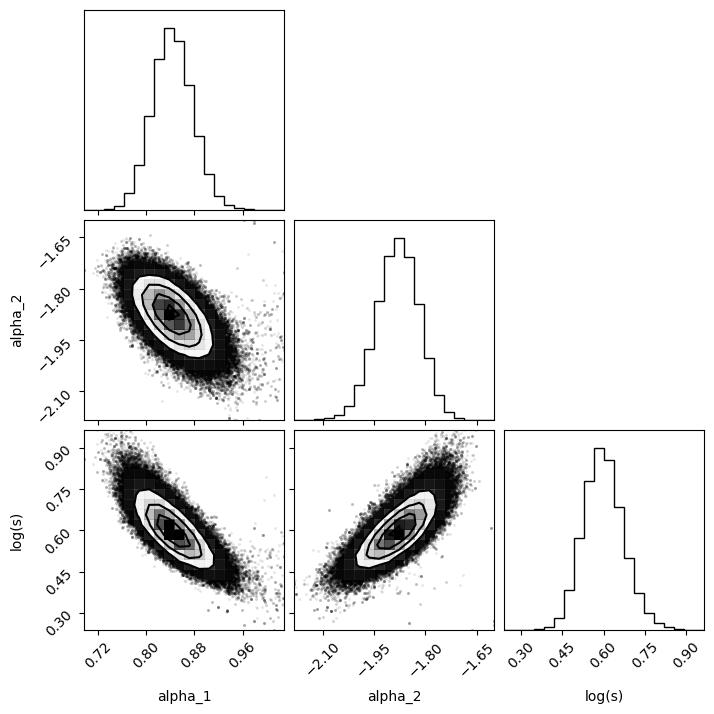

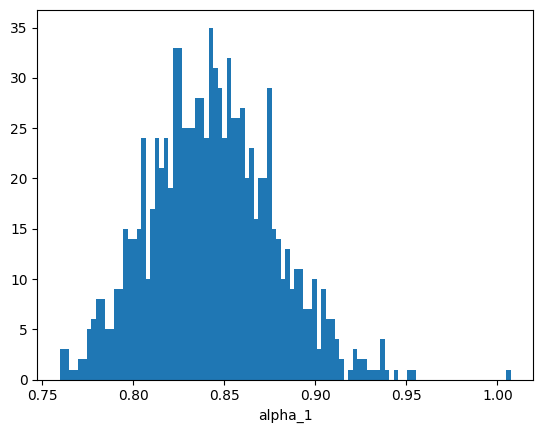

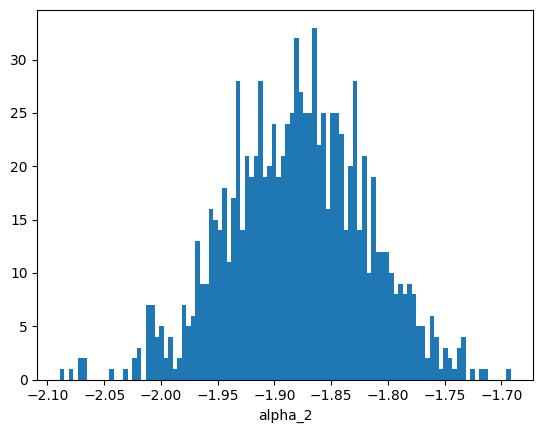

Mean of alpha_1:  0.8441810043207567
Std of alpha_1:  0.033403777715108905
Mean of alpha_2:  -1.8805099548474906
Std of alpha_2:  0.061028859795451126
Mean of log(s):  0.6007098622870296
Std of log(s):  0.07341487682760975


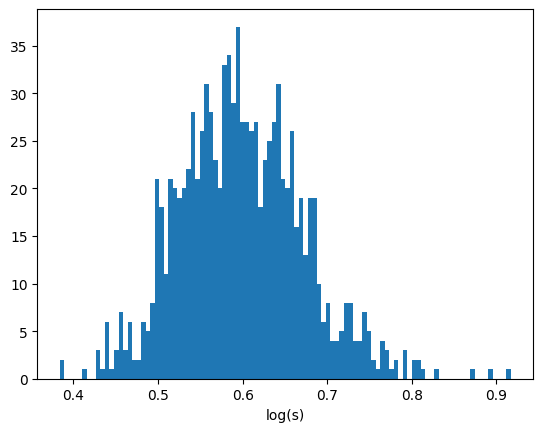

In [62]:
# Now we do some processing on the data of the chain.

#Firstly we remove the first 1000 steps as burn in
samples = sampler.flatchain[1000:, :]
# Some positive alpha_2 and negative alpha_1 are present in the chain which have to be removed
samples = samples[(samples[:, 0] > 0) & (samples[:, 1] < 0)]
# Thirdly we convert the samples in s to log(s) to make it easier to plot
samples[:, 2] = np.log10(samples[:, 2])
# Now we plot individual histograms
# We clean up the samples by removing alpha_1s and alpha_2s with particular Z values (>3 for now)
z= 5
alpha_1_mean = np.mean(samples[:, 0])
alpha_1_std = np.std(samples[:, 0])
alpha_1_min = alpha_1_mean - z * alpha_1_std
alpha_1_max = alpha_1_mean + z * alpha_1_std
alpha_2_mean = np.mean(samples[:, 1])
alpha_2_std = np.std(samples[:, 1])
alpha_2_min = alpha_2_mean - z * alpha_2_std
alpha_2_max = alpha_2_mean + z * alpha_2_std
samples = samples[(samples[:, 0] > alpha_1_min) & (samples[:, 0] < alpha_1_max) & (samples[:, 1] > alpha_2_min) & (samples[:, 1] < alpha_2_max)]
s_mean = np.mean(samples[:, 2])
s_std = np.std(samples[:, 2])
s_min = s_mean - z * s_std
s_max = s_mean + z * s_std
samples = samples[(samples[:, 2] > s_min) & (samples[:, 2] < s_max)]



fig = corner.corner(samples, labels=["alpha_1", "alpha_2", "log(s)"])

# Individual histograms for each parameter
plt.show()
# Individual histogram showing 1000 samples of alpha_1. We only take 1000 randomly selected values for alpha_1
alpha_1_samples = samples[:, 0]
alpha_1_samples = np.random.choice(alpha_1_samples, 1000)
plt.hist(alpha_1_samples, bins=100)
plt.xlabel("alpha_1")
plt.show()
# Similarly for alpha_2
alpha_2_samples = samples[:, 1]
alpha_2_samples = np.random.choice(alpha_2_samples, 1000)
plt.hist(alpha_2_samples, bins=100)
plt.xlabel("alpha_2")
plt.show()
# Similarly for s
s_samples = samples[:, 2]
s_samples = np.random.choice(s_samples, 1000)
plt.hist(s_samples, bins=100)
plt.xlabel("log(s)")


# We also print the mean and std we get
print("Mean of alpha_1: ", np.mean(samples[:, 0]))
print("Std of alpha_1: ", np.std(samples[:, 0]))
print("Mean of alpha_2: ", np.mean(samples[:, 1]))
print("Std of alpha_2: ", np.std(samples[:, 1]))
print("Mean of log(s): ", np.mean(samples[:, 2]))
print("Std of log(s): ", np.std(samples[:, 2]))

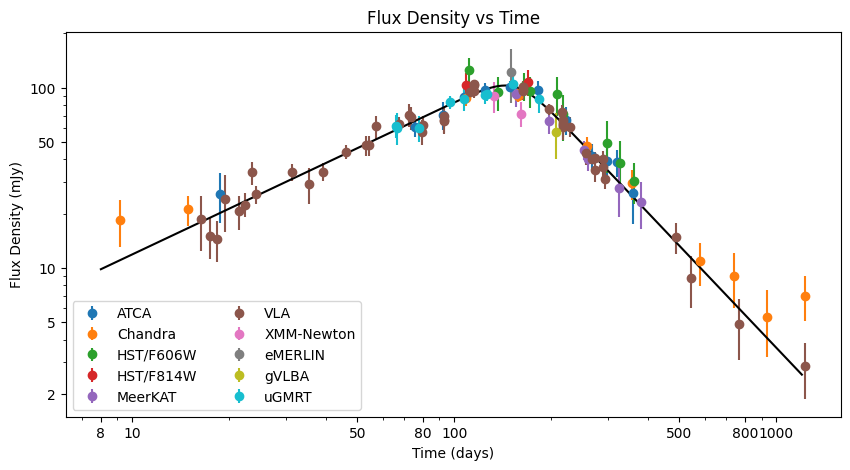

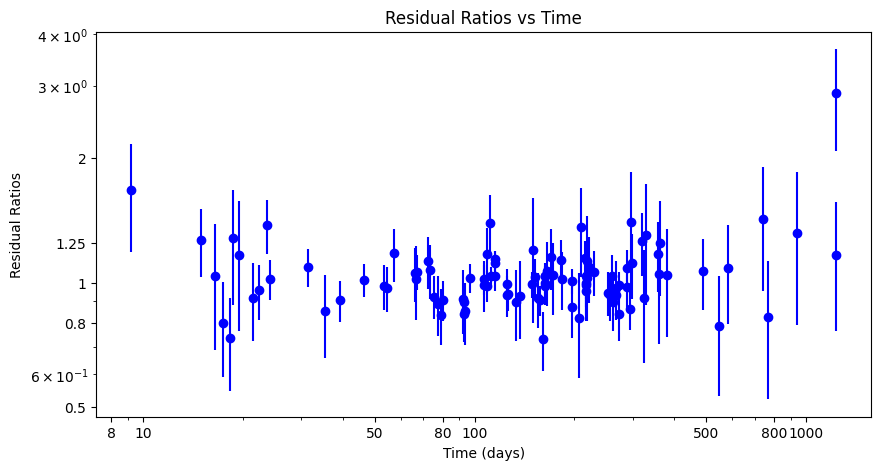

In [69]:
# Finally we plot the model with the best fit parameters
alpha_1 = np.mean(samples[:, 0])
alpha_2 = np.mean(samples[:, 1])
s = 10 ** np.mean(samples[:, 2])


# Now we plot the data (Basically we have recreated figure 1 from the paper)
# Making the plot a bit wider
plt.figure(figsize=(10, 5))

# We colour each data point by the telescope used
telescopes = data['Telescope']
telescopes = np.unique(telescopes)
# List of 10 colours
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
for i, telescope in enumerate(telescopes):
    data_telescope = Telescope_Filter(data, telescope)
    plt.errorbar(data_telescope['T'], data_telescope['FluxD'], yerr=data_telescope['FluxDErr'], fmt='o', label=telescope, color=colors[i])

# Set logarithmic Scale
plt.xscale('log')
plt.yscale('log')
# Show the points 8, 10, 80 on the X axis, with label of the points
plt.xticks(ticks=[8, 10, 50, 80, 100, 500, 800, 1000], labels=['8', '10', '50', '80', '100', '500', '800', '1000'])
plt.yticks(ticks=[1, 2, 5, 10, 50, 100], labels=['1', '2', '5', '10', '50', '100'])
plt.xlabel('Time (days)')
plt.ylabel('Flux Density (mJy)')
plt.title('Flux Density vs Time')
# Have two columns for the legend
plt.legend(ncol=2)


# We also plot the fitted model
times = np.linspace(8, 1200, 1000)
plt.plot(times, flux(alpha_1, alpha_2, s, times), label='Best Fit Model', color='black')
plt.show() 


# We also plot the residual ratios
plt.figure(figsize=(10, 5))
plt.errorbar(data["T"], data["FluxD"] / flux(alpha_1, alpha_2, s, data["T"]), yerr=data["FluxDErr"] / flux(alpha_1, alpha_2, s, data["T"]), fmt='o', label='Residual Ratios', color='blue')
plt.xscale('log')
plt.xlabel('Time (days)')
plt.ylabel('Residual Ratios')
plt.title('Residual Ratios vs Time')
plt.xticks(ticks=[8, 10, 50, 80, 100, 500, 800, 1000], labels=['8', '10', '50', '80', '100', '500', '800', '1000'])
plt.yscale('log')
plt.yticks(ticks=[0.5, 0.8, 1, 1.25, 2], labels=['0.5', '0.8', '1', '1.25', '2'])
plt.show()

In [74]:
#Now we try to run a fit with the entire formula for the dataset

data = ascii.read('data.txt')

# Remove all data points whose fluxD begins with <
data = data[~np.array([re.match(r'<', str(i)) is not None for i in data['FluxD']])]

# Convert the fluxD to float
data['FluxD'] = data['FluxD'].astype(float)
# Now we scale the fluxD for the data

times = data["T"]
fluxes = data["FluxD"]
errors = data["FluxDErr"]


def flux(alpha_1, alpha_2, s, beta, F_p, t_p, times):
    a = 2 ** (1/s)
    b = (times / t_p) ** (-s * alpha_1)
    c = (times / t_p) ** (-s * alpha_2)
    d = (b + c) ** (-1/s)
    return d * a * F_p * (times / 3e9)**(-beta)

def lnprior(p):
    alpha_1, alpha_2, s, beta, F_p, t_p = p
    if 0.1 < s and 0 < alpha_1 < 10 and -10 < alpha_2 < 0 and 0 < beta < 1 and 10 < F_p < 200 and 10 < t_p < 200:
        return 0
    return -np.inf

def lnlike(params, x, y, yerr):
    alpha_1, alpha_2, s, beta, F_p, t_p = params
    model = flux(alpha_1, alpha_2, s, beta, F_p, t_p, x)
    inv_sigma2 = 1.0 / (yerr ** 2)
    return -0.5 * (np.sum((y - model) ** 2 * inv_sigma2 - np.log(inv_sigma2)))


Nwalker, Ndim = 50, 6
var = 1
# Cheating a bit with param_0 but fine
param_0 = [0, 0, 1, 0.5, 100, 155]
pos = [param_0 + var * np.random.randn(Ndim) for i in range(Nwalker)]
for i in range(Nwalker):
    while not np.isfinite(lnprior(pos[i])):
        pos[i] = param_0 + var * np.random.randn(Ndim)


In [75]:
# Running the MCMC
sampler = emcee.EnsembleSampler(Nwalker, Ndim, lnprob, args=(times, fluxes, errors))
sampler.run_mcmc(pos, 50000)

# Convert to log for s
samples = sampler.flatchain[1000:, :]
samples[:, 2] = np.log10(samples[:, 2])

/tmp/ipykernel_815967/1479448621.py:19: RuntimeWarning: overflow encountered in power
  b = (times / t_p) ** (-s * alpha_1)
/tmp/ipykernel_815967/1479448621.py:20: RuntimeWarning: overflow encountered in power
  c = (times / t_p) ** (-s * alpha_2)


State([[ 5.19628615e+00 -7.26186368e+00  1.40662517e+03  7.55049629e-02
   1.99432628e+01  1.23350066e+02]
 [ 1.80555818e-02 -5.36992127e+00  8.36397092e+06  1.84015412e-02
   3.28241685e+01  1.63479289e+02]
 [ 1.28884112e+00 -8.70920000e-04  7.48832646e+08  7.08482819e-02
   1.49640950e+01  1.62982185e+02]
 [ 1.24859260e-01 -6.92417775e+00  2.85625170e+06  3.19298494e-02
   2.67701476e+01  1.63121794e+02]
 [ 1.55070276e-02 -7.62381949e+00  2.73577624e+05  5.80872965e-02
   1.77250948e+01  1.32363991e+02]
 [ 3.61063682e+00 -5.54493997e+00  1.85930342e+07  2.74945786e-03
   4.38508952e+01  1.62999284e+02]
 [ 5.87904995e+00 -3.96157069e-02  1.40582229e+05  6.69547280e-02
   1.53652249e+01  1.11164090e+02]
 [ 3.48029086e+00 -6.54605592e+00  5.56732140e+07  1.66693432e-02
   3.37090494e+01  1.63000004e+02]
 [ 6.46022231e+00 -1.83483668e-01  1.86748167e+09  1.23936492e-03
   4.37567928e+01  1.62999721e+02]
 [ 1.07334205e+00 -5.64126897e+00  1.04750107e+07  3.75819098e-02
   2.37050163e+01  

In [79]:
# Cleaning up the data
samples = sampler.flatchain[1000:, :]
z = 5
# Taking log of s
# Removing the samples that are too far away from the mean

alpha_1_mean = np.mean(samples[:, 0])
alpha_1_std = np.std(samples[:, 0])
alpha_1_min = alpha_1_mean - z * alpha_1_std
alpha_1_max = alpha_1_mean + z * alpha_1_std
alpha_2_mean = np.mean(samples[:, 1])
alpha_2_std = np.std(samples[:, 1])
alpha_2_min = alpha_2_mean - z * alpha_2_std
alpha_2_max = alpha_2_mean + z * alpha_2_std
samples = samples[(samples[:, 0] > alpha_1_min) & (samples[:, 0] < alpha_1_max) & (samples[:, 1] > alpha_2_min) & (samples[:, 1] < alpha_2_max)]
s_mean = np.mean(samples[:, 2])
s_std = np.std(samples[:, 2])
s_min = s_mean - z * s_std
s_max = s_mean + z * s_std
samples = samples[(samples[:, 2] > s_min) & (samples[:, 2] < s_max)]
beta_mean = np.mean(samples[:, 3])
beta_std = np.std(samples[:, 3])
beta_min = beta_mean - z * beta_std
beta_max = beta_mean + z * beta_std
samples = samples[(samples[:, 3] > beta_min) & (samples[:, 3] < beta_max)]
F_p_mean = np.mean(samples[:, 4])
F_p_std = np.std(samples[:, 4])
F_p_min = F_p_mean - z * F_p_std
F_p_max = F_p_mean + z * F_p_std
samples = samples[(samples[:, 4] > F_p_min) & (samples[:, 4] < F_p_max)]
t_p_mean = np.mean(samples[:, 5])
t_p_std = np.std(samples[:, 5])
t_p_min = t_p_mean - z * t_p_std
t_p_max = t_p_mean + z * t_p_std
samples = samples[(samples[:, 5] > t_p_min) & (samples[:, 5] < t_p_max)]

In [80]:
# Finally we get the full corner plot
fig = corner.corner(samples, labels=["alpha_1", "alpha_2", "log(s)", "beta", "F_p", "t_p"])

AssertionError: I don't believe that you want more dimensions than samples!